<a href="https://colab.research.google.com/github/gal-dmitry/HSE_DUL/blob/hw_12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 384 (delta 120), reused 102 (delta 69), pack-reused 171
Receiving objects: 100% (384/384), 55.95 MiB | 21.26 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=f7bbd9cb95883f0b2bb47453a853c691b82ce85e7a9e5673e87deafc44bef75e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6n0qmjgo/wheels/55/59/29/0fb1c635652

In [3]:
from dul_2021.utils.hw12_utils import *

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.optim import Adam
from tqdm.auto import tqdm, trange
  
import contextlib

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [18]:
from torch.optim import Adam
from tqdm.auto import tqdm, trange

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [47]:
class Net(nn.Module): 
    def __init__(self, n_classes=10): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(),

            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(), 

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(), 
            
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(), 

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            
            nn.BatchNorm1d(128), 
            nn.LeakyReLU(), 

            nn.Linear(128, n_classes)
        )

    def forward(self, x): 
        return self.model(x)

In [48]:
@contextlib.contextmanager
def disable_tracking_bn_stats(model):
    def switch_attr(m):
        if hasattr(m, "track_running_stats"):
            m.track_running_stats ^= True
       
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)


def _l2_normalize(x): 
    x_reshaped = x.view(x.shape[0], -1)
    x_reshaped_norm = F.normalize(x_reshaped, p=2, dim=1)
    x = x_reshaped_norm.view(x.shape)
    return x


def get_acc(clf, test_loader): 
    clf.eval()
    total = 0
    true = 0
    with torch.no_grad(): 
        for batch in tqdm(test_loader, desc="Batch: get acc"):
            x, y = batch
            x, y = x.float().to(device), y.to(device)
            pred = clf(x)
            true += (torch.argmax(pred, dim=1) == y).sum().item()
            total += len(x)
    return true / total


def get_loss(get_loss_l, get_loss_ul, coef, x, y, mode="VAT"):
    labeled = (y != -1)
    x_hat = x[~labeled] if mode == "FixMatched" else x

    loss_l = get_loss_l(x[labeled], y[labeled])
    loss_ul = get_loss_ul(x_hat)
    total_loss = loss_l + coef * loss_ul
    return loss_l, loss_ul, total_loss


def fit(clf, get_acc, get_loss, train_loader, test_loader, epochs=20, lr=5e-4):
        clf.train()
        optim = Adam(clf.parameters(), lr=lr)
        losses = []
        accs = []

        for epoch in trange(epochs, desc="Fit"):
            accs.append(get_acc(test_loader))

            for batch in tqdm(train_loader, desc="Batch: fit"):
                x, y = batch
                x, y = x.float().to(device), y.to(device)
                _, _, loss = get_loss(x, y)
                losses.append(loss.item())

                optim.zero_grad()
                loss.backward()
                optim.step()

        return np.array(losses), np.array(accs)

In [49]:
class VAT(nn.Module): 
    def __init__(self, n_classes=10, eps=10.0, alpha=1.0): 
        super().__init__()
        self.clf = Net(n_classes=n_classes)
        self.eps = eps
        self.alpha = alpha


    def get_loss_l(self, x, y): 
        return F.cross_entropy(self.clf(x), y, reduction="none").mean()

    ### https://github.com/lyakaap/VAT-pytorch/blob/master/vat.py :(
    def get_loss_ul(self, x):  
        with torch.no_grad():
            pred = F.softmax(self.clf(x), dim=1)

        d = torch.empty(x.shape).normal_(mean=0, std=1).to(device)
        d = _l2_normalize(d)

        with disable_tracking_bn_stats(self.clf):
            r = self.eps * d
            r.requires_grad_()
            pred_hat = self.clf(x + r)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            adv_distance = F.kl_div(logp_hat, pred, reduction="batchmean")
            adv_distance.backward()
            r_adv = _l2_normalize(r.grad)
            self.clf.zero_grad()
    
            pred_hat = self.clf(x + r_adv)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            lds = F.kl_div(logp_hat, pred, reduction="batchmean")
        return lds


    def get_loss(self, x, y):
        return get_loss(self.get_loss_l, self.get_loss_ul, self.alpha, x, y, mode="VAT")


    def get_acc(self, test_loader): 
        return get_acc(self.clf, test_loader)


    def fit(self, train_loader, test_loader, epochs=20, lr=5e-4):
        return fit(self.clf, self.get_acc, self.get_loss, train_loader, test_loader, epochs=epochs, lr=lr)

In [50]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    batch_size = 128
    # epochs=15
    epochs=2
    lr = 5e-4
    eps=10.0 
    alpha=1.0

    train_loader = DataLoader(train_data, 
                              batch_size=batch_size, 
                              shuffle=True) 
    
    test_loader = DataLoader(test_data, 
                             batch_size=batch_size, 
                             shuffle=False)

    model = VAT(n_classes=10, eps=eps, alpha=alpha).to(device)
    losses, accs = model.fit(train_loader, test_loader, epochs=epochs, lr=lr)

    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


Fit:   0%|          | 0/2 [00:00<?, ?it/s]

Batch: get acc:   0%|          | 0/79 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/391 [00:00<?, ?it/s]

Batch: get acc:   0%|          | 0/79 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/391 [00:00<?, ?it/s]

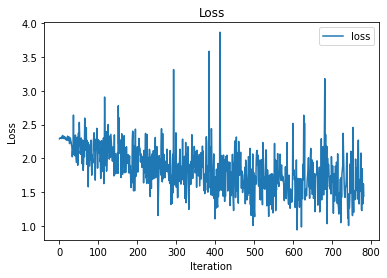

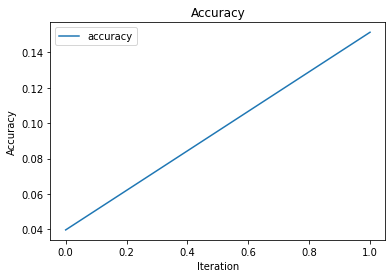

In [51]:
q12_results(q1)

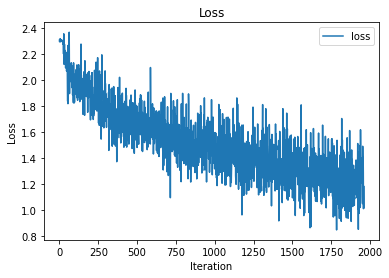

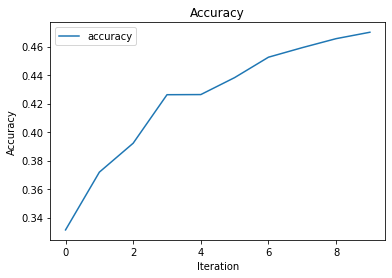

In [ ]:
### orig
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [53]:
class FixMatch(nn.Module): 

    def __init__(self, n_classes=10, tau=0.7, lambda_u=10, threshold=0.95): 
        super().__init__()
        self.clf = Net(n_classes=n_classes)
        self.tau = tau
        self.lambda_u = lambda_u
        self.threshold = threshold
        self.weak_transform = transforms.RandomHorizontalFlip()
        self.strong_transform = transforms.Compose([
                transforms.RandomResizedCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
                transforms.RandomGrayscale(p=0.2)])


    def get_loss_l(self, x, y):
        return F.cross_entropy(self.clf(self.weak_transform(x)), y, reduction="none").mean()


    def get_loss_ul(self, x): 
        with torch.no_grad(): 
            y_weak = self.clf(self.weak_transform(x))
        y_strong = self.clf(self.strong_transform(x)) 

        y_hat = F.softmax(y_weak / self.tau, dim=1)
        y_pred, y_true = torch.max(y_hat, dim=-1)

        mask = y_pred.ge(self.threshold).float()
        return (F.cross_entropy(y_strong, y_true, reduction="none") * mask).mean()


    def get_loss(self, x, y):
        return get_loss(self.get_loss_l, self.get_loss_ul, self.lambda_u, x, y, mode="FixMatch")


    def get_acc(self, test_loader): 
        return get_acc(self.clf, test_loader)


    def fit(self, train_loader, test_loader, epochs=20, lr=5e-4):
        return fit(self.clf, self.get_acc, self.get_loss, train_loader, test_loader, epochs=epochs, lr=lr)


In [54]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    batch_size = 128
    # epochs=20
    epochs=2
    lr = 5e-4
    tau = 0.7
    lambda_u = 10
    threshold = 0.95

    train_loader = DataLoader(train_data, 
                              batch_size=batch_size, 
                              shuffle=True) 
    
    test_loader = DataLoader(test_data, 
                             batch_size=batch_size, 
                             shuffle=False)

    model = FixMatch(n_classes=10, tau=tau, lambda_u=lambda_u, threshold=threshold).to(device)
    losses, accs = model.fit(train_loader, test_loader, epochs=epochs, lr=lr)

    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


Fit:   0%|          | 0/2 [00:00<?, ?it/s]

Batch: get acc:   0%|          | 0/79 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/391 [00:00<?, ?it/s]

Batch: get acc:   0%|          | 0/79 [00:00<?, ?it/s]

Batch: fit:   0%|          | 0/391 [00:00<?, ?it/s]

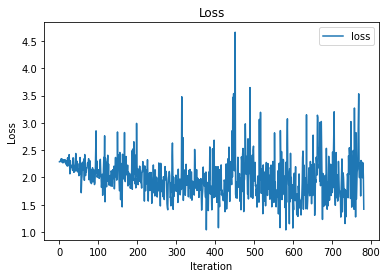

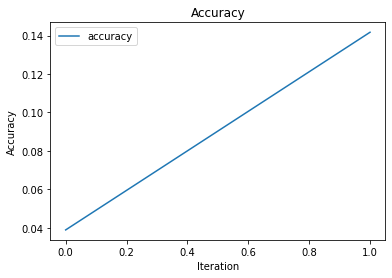

In [55]:
q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """